In [1]:
import numpy as np

from DORR_matrix import build_pauli_sum_A_strings, pauli_string_to_matrix, build_matrix_from_paulis

import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from device_var_lse_solver import DeviceVarLSESolver
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

def TRC_ASA(iteration_count : dict):
    trc = 0
    max_size = max(iteration_count)
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*max_size
    print(max_size)
    return trc

In [2]:
for KAPPA in [1.01,10]:
    pauli_strings, coeffs, b_state = build_pauli_sum_A_strings(qubits=3, J = 0.1, kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)

    cond = np.linalg.cond(A_mat)
    print(f"alpha = {KAPPA:.4e} -> condition number = {cond:.4e}")

b = np.ones(2**3)
b = b / np.linalg.norm(b)

alpha = 1.0100e+00 -> condition number = 1.0100e+00
alpha = 1.0000e+01 -> condition number = 1.0000e+01


In [ ]:
qubits = 3
n = 2 ** qubits
kappa_list = [1.01,10]


device = Device(DeviceType.QISKIT_AER, qubits=qubits)

save = True
redo_calc = 5


lr = 0.01
threshold = 0.0001
steps = 5000
epochs = 10
abort = 200



results_list_local = np.zeros([redo_calc, n])
results_list_global = np.zeros([redo_calc, n])
TRC_list_local = np.zeros(redo_calc)
TRC_list_global = np.zeros(redo_calc)


kappa_list = [1.01, 1.5, 2, 10]

for KAPPA in kappa_list:
    for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        A, coeffs, b = build_pauli_sum_A_strings(qubits=qubits, J=0.1, kappa=KAPPA)

        lse_dyn_local = DeviceVarLSESolver(A, 
                    b, 
                    coeffs=coeffs,
                    method="hadamard", 
                    local=True, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    device=device) 

        solution_local, param_local, it_count_local = lse_dyn_local.solve()
        local_dense_trc = TRC_ASA(it_count_local)
        results_list_local[i, :] = solution_local
        TRC_list_local[i] = local_dense_trc

    

        # lse_dyn_global = DeviceVarLSESolver(A, 
        #             b, 
        #             coeffs=coeffs,
        #             method="hadamard", 
        #             local=False, 
        #             lr=lr, 
        #             threshold=threshold,
        #             steps=steps,
        #             epochs=epochs, 
        #             device=device)
        # solution_global, param_global, it_count_global = lse_dyn_global.solve()
        # global_dense_trc = TRC_ASA(it_count_global)
        # results_list_global[i, :] = solution_global
        # TRC_list_global[i] = global_dense_trc



    if save == True:
        filename = f"data/result_local_condnr_{KAPPA}.npz"
        save_dict = {
            'A': A,
            'coeffs': coeffs,
            'b': b,
            'results_list_local': results_list_local,
            'TRC_list_local': TRC_list_local,
            #'results_list_global': results_list_global,
            #'TRC_list_global': TRC_list_global,
            'nr_runs': redo_calc,
            'KAPPA': KAPPA,
            'qubits': qubits,

        }
        np.savez(filename, **save_dict)
        print(f"Saved {filename}")

Run nr. 1/5
Epoch 1/10:   5%|▌         | 266/5000 [00:43<13:02,  6.05it/s, best loss=0.000106, last improvement in step=264, loss=0.000101]
Loss of 0.0000963061 below stopping threshold.
Returning solution.
1
Run nr. 2/5
Epoch 1/10:   5%|▍         | 237/5000 [00:44<14:48,  5.36it/s, best loss=0.000118, last improvement in step=235, loss=0.000108]
Loss of 0.0000993410 below stopping threshold.
Returning solution.
1
Run nr. 3/5
Epoch 1/10:   6%|▋         | 325/5000 [00:48<11:36,  6.72it/s, best loss=0.00011, last improvement in step=322, loss=0.0001]   
Loss of 0.0000955367 below stopping threshold.
Returning solution.
1
Run nr. 4/5
Epoch 1/10:   6%|▋         | 321/5000 [00:49<11:56,  6.53it/s, best loss=0.000107, last improvement in step=319, loss=0.000102]
Loss of 0.0000968635 below stopping threshold.
Returning solution.
1
Run nr. 5/5
Epoch 1/10:   6%|▌         | 312/5000 [00:46<11:39,  6.71it/s, best loss=0.000114, last improvement in step=310, loss=0.000105]
Loss of 0.0000970638 bel

In [5]:
mean_results = np.zeros([len(kappa_list), n])
std_results = np.zeros([len(kappa_list), n])
mean_trc = np.zeros(len(kappa_list))
std_trc = np.zeros(len(kappa_list))


classical_solution = np.zeros([len(kappa_list), n])

for i, KAPPA in enumerate(kappa_list):

    filename = f"data/result_local_condnr_{KAPPA}.npz"
    data = np.load(filename)
    
    A = data['A']
    coeffs = data['coeffs']
    b = data['b']
    results_list_local = data['results_list_local']
    TRC_list_local = data['TRC_list_local']
    # results_list_global = data['results_list_global']
    # TRC_list_global = data['TRC_list_global']
    nr_runs = data['nr_runs']
    KAPPA = data['KAPPA']
    qubits = data['qubits'] 


    mean_results[i, :] = np.mean(results_list_local, axis=0)
    std_results[i, :] = np.std(results_list_local, axis=0)
    mean_trc[i] = np.mean(TRC_list_local)
    std_trc[i] = np.std(TRC_list_local)

    # compute normalized classical solution for comparison, therefore first re-compose system matrix A
    pauli_strings, coeffs, b = build_pauli_sum_A_strings(qubits=int(qubits), kappa=KAPPA)
    A_mat = build_matrix_from_paulis(pauli_strings, coeffs)
    x_classical = np.linalg.solve(A_mat, b)
    normalized_classical_solution = np.square(np.abs(x_classical / np.linalg.norm(x_classical)))

    classical_solution[i, :] = normalized_classical_solution



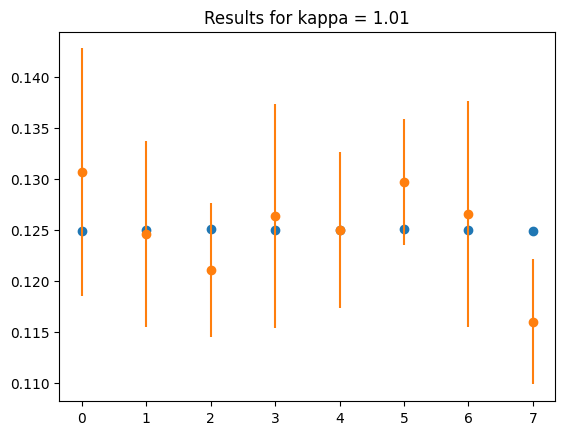

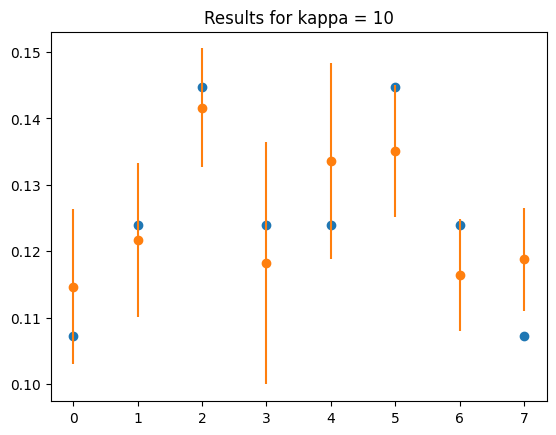

In [6]:
for i, KAPPA in enumerate(kappa_list):
    plt.figure()
    plt.title(f"Results for kappa = {KAPPA}")
    plt.plot(classical_solution[i, :], 'o')
    plt.errorbar(np.arange(n), mean_results[i, :], yerr=std_results[i, :], fmt='o')
    plt.show()